# NEO Telescope Prediction

The last notebook of this NEO project! We finalize it with a NEO detection simulation using telescope and CCD properties! Please execute 14_1 to compute the apprent magnitude of our enriched NEO population + the corresponding irradiance values.

In [1]:
# Standard libraries
import datetime
import math
import pathlib
import re
import requests
import sqlite3
import sys

# Installed libraries
from matplotlib import pyplot as plt
from matplotlib import ticker
import numpy as np
import pandas as pd
import sklearn
import spiceypy
import tqdm

# Append to root directory of this repository
sys.path.append("../")

# Auxiliary module that contains the apparent magnitude
from auxiliary import photometry

# TQDM has a nice Pandas implementation that allows us to display the progress of "apply" functions
tqdm.tqdm.pandas()

In [2]:
# Let's set a dark background
plt.style.use('dark_background')

# Set a default font size for better readability
plt.rcParams.update({'font.size': 14})

In [3]:
# Load SPICE kernels
spiceypy.furnsh("../kernels/spk/de432s.bsp")
spiceypy.furnsh("../kernels/lsk/naif0012.tls")
spiceypy.furnsh("../kernels/pck/gm_de431.tpc")

# Get the G*M value of the Sun
_, gm_sun_pre = spiceypy.bodvcd(bodyid=10, item='GM', maxn=1)
gm_sun = gm_sun_pre[0]

In [4]:
# Load the Granvik model
data_dir = pathlib.Path("results_data/Granvik")
data_dir.mkdir(parents=True, exist_ok=True)
dataframe_filepath = data_dir / "enriched_granvik_model_w_irradiance.parquet"

granvik_model_df = pd.read_parquet(dataframe_filepath)

# As shown in previous notebooks, we need to transform the longitude values to plot them in a
# matplotlib map projection
granvik_model_df.loc[:, "earth2neo_eclip_long_4plot"] = \
    granvik_model_df["earth2neo_eclip_long"].apply(lambda x: -1*((x % np.pi) - np.pi)
                                                             if x > np.pi
                                                             else -1*x)

In [5]:
# Define a function that computes the "collected watts" based on the object's irradiance and
# telescope optics
def collect_watts(irradiance, total_area, reflectance):
    
    return irradiance * total_area * reflectance

In [6]:
# Now we need to convert the energy rate to a signal, based on the exposure time, the object,
# how much light of the 2D Gaussian falls into the center pixel, as well as the quantum efficiency
# of the corresponding band (we'll simplify these things with the V-Band and some basic
# approximations)
def watts2signal(exp_time,
                 obj_watts,
                 center_ratio,
                 mean_lambda,
                 mean_qe):

    # We'll consider a max. resolution of 16 bit
    max_dn = 2**(16) - 1
    
    # Some constants
    planck_h = 6.62607015 * 10**(-34)
    light_c = 299792458.0
    
    # ... to compute the mean energy of a given wavelength
    mean_watt = (planck_h * light_c) / (mean_lambda)
    
    # Compute the "Digital Number" of an object
    dn = int(exp_time * center_ratio * (obj_watts / mean_watt) * mean_qe)
    
    # If it exceeds the resolution, set the max_dn as a level
    if dn > max_dn:
        dn = max_dn
        
    return dn

In [7]:
# A simple and basic function to compute the Signal-To-Noise ratio without considering other bias
# effects like read-out, background noise, etc.
def signal2noise(signal):
    
    return signal / np.sqrt(signal)

In [8]:
# Telescope settings
telescope_total_area = 0.12 # m^2
telescope_reflectance = 0.8 #

# CCD + Atmosphere Effects
ccd_center_ratio = 0.25 #
ccd_mean_lambda = 550.0 * (10 ** (-9.0)) # meters (V-Band)
ccd_mean_qe = 0.5 #

# Observation Setting
operation_exp_time = 60 # seconds

In [9]:
# In this block we compute now step by step the NEO objects' wats, signal, SNR and ...
granvik_model_df.loc[:, "watts"] = \
    granvik_model_df.progress_apply(lambda x: collect_watts(irradiance=x["irradiance"],
                                                            total_area=telescope_total_area,
                                                            reflectance=telescope_reflectance),
                                    axis=1)

granvik_model_df.loc[:, "signal"] = \
    granvik_model_df.progress_apply(lambda x: watts2signal(exp_time=operation_exp_time,
                                                           obj_watts=x["watts"],
                                                           center_ratio=ccd_center_ratio,
                                                           mean_lambda=ccd_mean_lambda,
                                                           mean_qe=ccd_mean_qe),
                                    axis=1)

granvik_model_df.loc[:, "snr"] = \
    granvik_model_df.progress_apply(lambda x: signal2noise(x["signal"]), axis=1)

# ... based on an SNR of 5, whether an object is detectable or not
granvik_model_df.loc[:, "detected"] = \
    granvik_model_df.progress_apply(lambda x: 1 if x["snr"]>=5 else 0, axis=1)

  0%|                                                      | 1/4812000 [00:04<5857:07:58,  4.38s/it]/var/folders/gc/021rhjrn20v7m9sjnfk08_fc0000gp/T/ipykernel_75667/3769508663.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return signal / np.sqrt(signal)
100%|██████████████████████████████████████████████████| 4812000/4812000 [00:50<00:00, 95426.89it/s]


In [10]:
# Get the detected ones
detec_granvik_model_df = granvik_model_df.loc[granvik_model_df["detected"]==1]

Text(0, 0.5, 'Signal to Noise ratio')

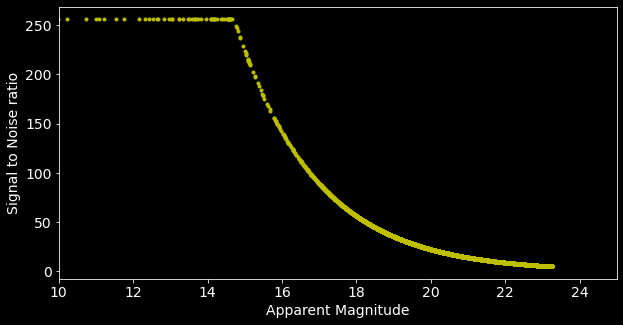

In [11]:
# Let's check the distribution of apparent magnitude and corresponding SNR
plt.figure(figsize=(10, 5))
plt.plot(detec_granvik_model_df["app_mag"],
         detec_granvik_model_df["snr"], 'y.')
plt.xlim(10, 25)

plt.xlabel("Apparent Magnitude")
plt.ylabel("Signal to Noise ratio")

## Filter NEO model

Let's filter our model data and take a look at the corresponding scatter plot of the sky coordinates

In [12]:
# In this cell, you can filter the data as you wish!
filtered_granvik_model_df = \
    detec_granvik_model_df[detec_granvik_model_df[f"ang_dist_neo2sun_deg"] >= 45.0].copy()

# Please note: We obtain the latitude and THEN the longitude. Why? Take a look at the KDE cell.
neo_positions_coord = filtered_granvik_model_df[["earth2neo_eclip_lat",
                                                 "earth2neo_eclip_long_4plot"]].values

In [13]:
print(f"Number of de-enriched NEOs: {len(neo_positions_coord) / 6}")

Number of de-enriched NEOs: 4714.666666666667


In [14]:
# Get th ET and ...
time_et = granvik_model_df["epoch_et"].iloc[0]

# ... determine the positional vector of the Sun as seen from Earth and compute the corresponding
# sky coordiantes
earth2sun_position_vec = spiceypy.spkgps(targ=10,
                                         et=time_et,
                                         ref="ECLIPJ2000",
                                         obs=399)[0]
_, sun_ecl_long, sun_ecl_lat = spiceypy.recrad(earth2sun_position_vec)

# Convert the values to determine the "Opposition Direction"
sun_opp_ecl_long = (sun_ecl_long + np.pi) % (2.0 * np.pi)
sun_opp_ecl_lat = -1.0 * sun_ecl_lat

# We need to transform the longitude values for matplotlib
sun_ecl_long_4plot = \
    -1*((sun_ecl_long % np.pi) - np.pi) if sun_ecl_long > np.pi else -1*sun_ecl_long
sun_opp_ecl_long_4plot = \
    -1*((sun_opp_ecl_long % np.pi) - np.pi) if sun_opp_ecl_long > np.pi else -1*sun_opp_ecl_long

## Kernel Density Estimator

Now use a KDE to create a density plot! Please note: we use the haversine metric that requires the input order "latitude / longitude" (see more [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html)).

Additionally, we use an exponential kernel.

Sampling vectors on a unit-sphere can be done with the [von Mises-Fisher distribution](https://en.wikipedia.org/wiki/Von_Mises–Fisher_distribution). A von Mises-Fisher based kernel would be the best approach. However, currently there is no implementation in scikit-learn. Some less known "side-project" repositories offer miscellaneous solutions. Here, we stay with default kernels and bandwidths.

In [15]:
# We apply a broad kerne with a size of 5 degrees to smooth the resulting distribution
import sklearn.neighbors
kde = sklearn.neighbors.KernelDensity(bandwidth=np.radians(5),
                                      metric="haversine",
                                      kernel="exponential",
                                      algorithm="ball_tree")
kde.fit(neo_positions_coord)

KernelDensity(algorithm='ball_tree', bandwidth=0.08726646259971647,
              kernel='exponential', metric='haversine')

In [16]:
# Compute the PDF in a long-lat mesh grid
sample_lat, sample_long = np.meshgrid(np.linspace(-0.5*np.pi, 0.5*np.pi, 100),
                                      np.linspace(-np.pi, np.pi, 100))
latlong = np.vstack([sample_lat.ravel(),
                     sample_long.ravel()]).T
sky_pdf = np.exp(kde.score_samples(latlong))
sky_pdf = sky_pdf.reshape(sample_lat.shape)

([<matplotlib.axis.XTick at 0x7fbce57752e0>,
 [Text(-2.6179938779914944, 0, '150°'),
  Text(-2.0943951023931953, 0, '120°'),
  Text(-1.5707963267948966, 0, '90°'),
  Text(-1.0471975511965976, 0, '60°'),
  Text(-0.5235987755982988, 0, '30°'),
  Text(0.0, 0, '0°'),
  Text(0.5235987755982988, 0, '330°'),
  Text(1.0471975511965976, 0, '300°'),
  Text(1.5707963267948966, 0, '270°'),
  Text(2.0943951023931953, 0, '240°'),
  Text(2.6179938779914944, 0, '210°')])

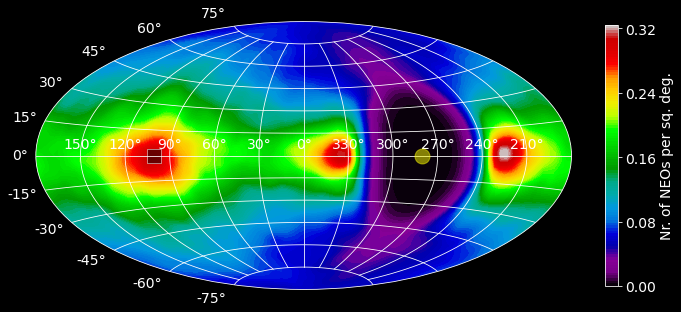

In [17]:
# We plot now the final figure of the sky-based PDF

# First we compute the resulting NEO density in 1/deg^2. Use the PDF, consider the number of all
# NEOs (len(neo_positions_coord)). This leads to the number of NEOs per Steradian. We apply now
# (180/pi)^2 to convert the result to NEOs/deg^2. However, since we enriched the NEO model in script
# number 12 by a factor of 6 we need to divide it by 6 to obtain the final density
neo_density = sky_pdf * len(neo_positions_coord)/(180/math.pi)**2 / 6

# Set a figure
plt.figure(figsize=(12, 8))

# Apply the aitoff projection and activate the grid
plt.subplot(projection="aitoff")
plt.grid(True)

# Create a color contour plot (filled)
CS = plt.contourf(sample_long,
                  sample_lat,
                  neo_density,
                  levels=np.linspace(0, np.max(neo_density), 100),
                  cmap=plt.cm.nipy_spectral)
cbar = plt.colorbar(CS, shrink=0.6)
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.set_label("Nr. of NEOs per sq. deg.")

# Add the Sun
plt.plot(sun_ecl_long_4plot,
         sun_ecl_lat,
         color="yellow",
         marker="o",
         markersize=15,
         alpha=0.5)

# Add the Opposition point
plt.scatter(sun_opp_ecl_long_4plot,
            sun_opp_ecl_lat,
            color="black",
            marker="s",
            s=200,
            alpha=0.5,
            edgecolor='white')

# Replace the standard x ticks (longitude) with the ecliptic coordinates
plt.xticks(ticks=np.radians([-150, -120, -90, -60, -30, 0, \
                             30, 60, 90, 120, 150]),
           labels=['150°', '120°', '90°', '60°', '30°', '0°', \
                   '330°', '300°', '270°', '240°', '210°'])

## Outlook

Feel free to extend this idea! Add more noise sources, determine the velocity of each NEO on the CCD chip. Consider modelling a 2D Gaussian and so on! Happy coding!

We conclude now the NEO project. New stuff, soon!